# Guitar Tuner
### Author: Pawel Budzynski

In this notebook Fourier transformation was used to perform spectral analysis of audio recordings to determine frequency of a sound. The goal is to guess which guitar string was played to make the sound and compute accuracy in cents taking the theoretical frequency as a point of reference.

In [1]:
import enum
from typing import List, Optional, Tuple

import IPython
import matplotlib.pyplot as plt
import numpy as np
import scipy.fft
import scipy.signal
import scipy.io.wavfile

To start with, the sound file is loaded using the `scipy` library. The sound representation is an array of floating points numbers. Additionally, sample rate is given which will be helpful to determine correct peak frequency after Fourier transformation. 

In [2]:
sample_rate_1, sound_1 = scipy.io.wavfile.read("string_1.wav")
IPython.display.Audio("string_1.wav")

Before starting with the analysis one may have a look on the sound data. To get some intuition let's plot the sound in the time domain. Sampling frequency may be used to adjust time axis. 

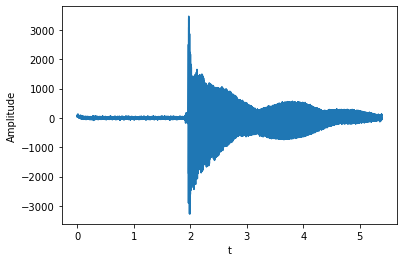

In [3]:
t_max = len(sound_1) / sample_rate_1
t = np.linspace(0, t_max, len(sound_1))
plt.plot(t, sound_1)
plt.xlabel("t")
plt.ylabel("Amplitude")
plt.show()

Let's have a look on the same sound in the frequency domain. For that, Fourier transform should be applied to the sound data. As the result of `scipy.fft.fft` gives symetrical result `scipy.fft.rfft` is used to avoid extra work connected with shifting the data towards zero middle. The result of Fourier transform is an array of complex numbers thus absolute value is taken. For better visual representatiton the result will be cropped as the rough range of expected frequencies is known beforehand. Hence the sound is guitar string played it is reasonable to expect peak frequency lower than 1000 Hz.

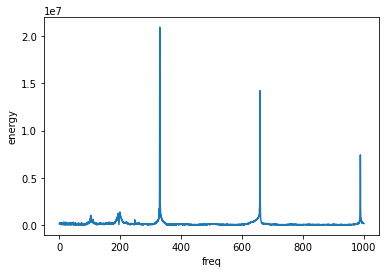

In [4]:
yf = scipy.fft.rfft(sound_1)
xf = scipy.fft.rfftfreq(len(sound_1), 1/sample_rate_1)

mask = xf < 1000
xf = xf[mask]
yf = yf[mask]

plt.plot(xf, np.abs(yf))
plt.xlabel("freq")
plt.ylabel("energy")
plt.show()

To find the peak frequency a function for peak detection was used. The search for peaks was performed with respect to the threshold of 25% of the maximum peak. In the plot one can see three peaks. Let's try to determine their corresponding frequencies. 

In [5]:
peaks, _ = scipy.signal.find_peaks(
    np.abs(yf), 
    height=np.max(np.abs(yf))*0.25,
)

for peak in peaks:
    print(f"{round(xf[peak], 2)} Hz")

329.68 Hz
330.05 Hz
659.18 Hz
988.67 Hz


The result of the search returns 4 peaks. However the two first seem to be very colse one another. Furthermore, higher values seem to be multiplications of the lower one. After skipping the doubled peak value a comparison was done to confirm that peaks are higher harmonic of the peak frequency. 

In [6]:
peaks = np.delete(peaks, 1)
peak_freq = xf[peaks[0]]
for i, peak in enumerate(peaks):
    print(xf[peak], '~', peak_freq*(i+1))

329.68076508620686 ~ 329.68076508620686
659.1758991109914 ~ 659.3615301724137
988.6710331357758 ~ 989.0422952586206


Keeping in mind that the peak does not always corresponds to one of the frequencies we are searching for the analysis will be made for a couple of peaks found with the respect of a threshold expressed as a percentage of the value of maximum peak. In the sound above one can notice that the sting played was E1. In the following part of the notebook a set of functions was defined to facilitate automated classification of string played to build a guitar tuner. 

In [7]:
""" Define theoretical frequencies for the strings we want to support. """
class String(enum.Enum):
    E1 = 329.63
    B2 = 246.94
    G3 = 196.00
    D4 = 146.83
    A5 = 110.00
    E6 = 82.41

In [8]:
""" Define 1 cent value for each of the string frequencies to detemine accuracy. """
cent_acc = {
    String.E1: 0.15,
    String.B2: 0.15,
    String.G3: 0.15,
    String.D4: 0.08,
    String.A5: 0.08,
    String.E6: 0.04,
}

In [9]:
def get_fft(
    signal: np.ndarray, 
    sample_rate: int,
) -> Tuple[np.ndarray, np.ndarray]:
    """Get Fourier transform and frequencies for a given signal."""
    # Number of samples. 
    N = len(signal)
    
    # Interested only in "positive" (right-hand) part of the result.
    yf = scipy.fft.rfft(signal)
    xf = scipy.fft.rfftfreq(N, 1/sample_rate)
    
    # For this application we need only frequencies lower than 440 Hz 
    # as the highest frequency we want to classify is roughly 330 Hz.  
    mask = xf <= 440
    xf = xf[mask]
    yf = yf[mask]
    
    return yf, xf

In [10]:
def peak_frequencies(
    signal_fft: np.ndarray, 
    frequencies: np.ndarray, 
    threshold: float = 0.7,
) -> List[float]:
    """Find peak frequencies in a given signal respecting
    the threshold expressed as a percentage of maximum peak value.
    """
    abs_sig_fft = np.abs(signal_fft)
    peaks, _ = scipy.signal.find_peaks(
        abs_sig_fft, 
        height=np.max(abs_sig_fft)*threshold,
    )
    return [frequencies[idx] for idx in peaks]

In [11]:
def closest_string(freq: float) -> Tuple[String, float, float]:
    """ Take single frequency and return 'closest' string with
    the corresponding frequency difference.
    """
    distances = {string: string.value - freq for string in String}
    closest = min(distances, key=lambda v: abs(distances.get(v)))
    return closest, distances[closest], freq

def classify_string(frequencies: List[float]) -> Tuple[String, float, float]:
    """ Take a list of peak frequencies and search for 
    the closest frequency to match a string as peak frequency 
    may not necessarily be close to any of theoretical string frequencies.
    """
    strings = (closest_string(freq) for freq in frequencies)
    return min(strings, key=lambda x: abs(x[1]))

In [12]:
filenames = (
    "string_1.wav", 
    "string_2.wav", 
    "string_3.wav",
)

for filename in filenames:
    # Load the sound from a file.
    sample_rate, sound = scipy.io.wavfile.read(filename)
    # Get Fourier transform and frequencies for the sound.
    fft_signal, fft_freqs = get_fft(sound, sample_rate)
    # Find peak frequencies.
    freqs = peak_frequencies(fft_signal, fft_freqs, threshold=0.7)
    
    # Find the closest theoretical value and the difference.
    string, dist, frequency = classify_string(freqs)
    difference = dist / cent_acc[string]
    
    print(f"File: {filename}")
    print(f"\t- Classified: {string}({string.value}Hz)")
    print(f"\t- Peak frequency: {round(frequency, 2)}Hz")
    print(f"\t- Shift: {difference:.2} cent(s)\n")

File: string_1.wav
	- Classified: String.E1(329.63Hz)
	- Peak frequency: 329.68Hz
	- Shift: -0.34 cent(s)

File: string_2.wav
	- Classified: String.G3(196.0Hz)
	- Peak frequency: 196.54Hz
	- Shift: -3.6 cent(s)

File: string_3.wav
	- Classified: String.A5(110.0Hz)
	- Peak frequency: 110.12Hz
	- Shift: -1.5 cent(s)



# Conclusions
- Fourier transform allows to move from time domain to frequency domain. 
- The result of Fourier transform are complex numbers thus for frequency interpretation absolute values should be used. 
- Raw results of Fourier transform are symetrical and not centered around 0-point thus a shift must be applied or only one half of the results should be considered.
- The tallest peak is not always the correct one, what matters is the energy of the peak. 
- Peaks of harmonics are appearing periodically. 